In [1]:
import warnings
from typing import Callable, NamedTuple
from scipy import stats

from edgedroid.models.sampling.adaptive import _aperiodic_instant_iterator
from edgedroid.models.timings import *


class StepResult(NamedTuple):
    execution_time: float
    duration: float
    wait_time: float
    ttf: float
    num_samples: int
    energy: float


class EnergyCalculator:
    def __init__(self, ab_ratio: float, rtt: float, proc_time: float, P0: float = 1.0):
        tc = rtt - proc_time
        Pc = P0 * ((ab_ratio / tc) + 1)
        self._tc = tc
        self._comm_w = Pc
        self._idle_w = P0

    def get_alpha(self) -> float:
        return self._tc * (self._comm_w - self._idle_w)

    def get_beta(self) -> float:
        return self._idle_w

    def calc_energy(self, num_samples: int, duration: float) -> float:
        comm_time = self._tc * num_samples
        idle_time = duration - comm_time
        comm_energy = comm_time * self._comm_w
        idle_energy = idle_time * self._idle_w

        return comm_energy + idle_energy


def greedy_sampling(rtt: float, target_exec_time: float, energy_calc: EnergyCalculator) -> StepResult:
    num_samples = 1
    instant = 0.0

    while instant <= target_exec_time:
        instant += rtt
        num_samples += 1

    duration = instant + rtt

    energy = energy_calc.calc_energy(num_samples, duration)

    return StepResult(
        execution_time=target_exec_time,
        duration=duration,
        wait_time=instant - target_exec_time,
        ttf=duration - target_exec_time,
        num_samples=num_samples,
        energy=energy,
    )


def ideal_sampling(rtt: float, target_exec_time: float, energy_calc: EnergyCalculator) -> StepResult:
    duration = target_exec_time + rtt
    samples = 1
    energy = energy_calc.calc_energy(samples, duration)
    return StepResult(
        execution_time=target_exec_time,
        duration=duration,
        wait_time=0.0,
        ttf=duration - target_exec_time,
        num_samples=samples,
        energy=energy,
    )


def power_sampling(timing_estimator: ExecutionTimeModel, rtt: float, target_exec_time: float,
                   energy_calc: EnergyCalculator) -> StepResult:
    mean_exec_time = timing_estimator.get_mean_execution_time()
    instant_iter = _aperiodic_instant_iterator(
        mu=mean_exec_time,
        alpha=energy_calc.get_alpha(),
        beta=energy_calc.get_beta(),
    )
    # first instant doesn't depend on RTT
    instant = next(instant_iter)
    num_samples = 1

    while instant <= target_exec_time:
        instant = max(next(instant_iter), instant + rtt)
        num_samples += 1

    duration = instant + rtt
    energy = energy_calc.calc_energy(num_samples, duration)
    return StepResult(
        execution_time=target_exec_time,
        duration=duration,
        wait_time=duration - target_exec_time,
        ttf=duration - target_exec_time,
        num_samples=num_samples,
        energy=energy,
    )


def get_ground_truth_model() -> ExecutionTimeModel:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return ExpKernelRollingTTFETModel(neuroticism=1.0)


def get_reference_estimator() -> ExecutionTimeModel:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return FittedNaiveExecutionTimeModel(dist=stats.rayleigh)


sampling_estimators: Dict[str, Callable[[], ExecutionTimeModel]] = {
    "Low neuroticism"                  : lambda: ExpKernelRollingTTFETModel(neuroticism=0.0),
    "High neuroticism"                 : lambda: ExpKernelRollingTTFETModel(neuroticism=1.0),
    "ExGaussian fit,\nlow neuroticism" : lambda: DistExpKernelRollingTTFETModel(neuroticism=0.0,),
    "ExGaussian fit,\nhigh neuroticism": lambda: DistExpKernelRollingTTFETModel(neuroticism=1.0),
    "Rayleigh fit,\nlow neuroticism"   : lambda: DistExpKernelRollingTTFETModel(neuroticism=0.0, dist=stats.rayleigh),
    "Rayleigh fit,\nhigh neuroticism"  : lambda: DistExpKernelRollingTTFETModel(neuroticism=1.0, dist=stats.rayleigh)
}

In [2]:
from collections import deque


def pc_to_ratio(Pc: float, P0: float, tc: float) -> float:
    return tc * (Pc - P0) / P0


# P0 = 0.015
# proc_time = 0.3
# tc = 0.02
# rtt = proc_time + tc
# Pc = 0.045
# ab_ratio = pc_to_ratio(Pc, P0, tc)

# warmup_steps = 25
# samples_per_state = 100


def evaluate_models(repetition: int, P0: float, Pc: float, comm_time: float, proc_time: float, task_steps: int) -> pd.DataFrame:
    rtt = comm_time + proc_time
    ab_ratio = pc_to_ratio(Pc, P0, comm_time)

    power_ratio = Pc / P0
    time_ratio = comm_time / proc_time

    # rng = np.random.default_rng()

    energy_calc = EnergyCalculator(ab_ratio, rtt, proc_time, P0=P0)
    gt = get_ground_truth_model()

    prev_ttf = rtt
    ref_estimator = get_reference_estimator()
    rows = deque()
    for step in range(task_steps):
        exec_time = gt.advance(prev_ttf).get_execution_time()

        ref_estimator.advance(prev_ttf)
        ref_result = power_sampling(
            timing_estimator=ref_estimator,
            rtt=rtt,
            target_exec_time=exec_time,
            energy_calc=energy_calc,
        )

        rows.append({
            "Configuration": "Reference",
            "Power Ratio": power_ratio,
            "Alpha/Beta Ratio": ab_ratio,
            "Comm/Proc Delay Ratio": time_ratio,
            "Repetition": repetition,
            "Step": step + 1,
            "Execution time": exec_time,
            "Estimated mean execution time": ref_estimator.get_mean_execution_time(),
            "Samples": ref_result.num_samples,
            "Wait Time": ref_result.wait_time,
            "TTF": ref_result.ttf,
            "Duration": ref_result.duration,
            "Energy": ref_result.energy,
            "P0": P0,
            "Pc": Pc,
            "Comm time": comm_time,
            "Proc Time": proc_time,
        })
        prev_ttf = ref_result.ttf




    # generate random TTFs to put ground truth in a random state
    # ttfs = (rng.random(size=warmup_steps) * 6.0)
    # for ttf in ttfs:
    #     gt.advance(ttf)
    #
    # rows = deque()

    # generate execution times and reference data
    # exec_times = np.empty(samples_per_state)
    # exec_time = gt.get_execution_time()
    # ref_estimator = get_reference_estimator()
    # for ttf in ttfs:
    #     ref_estimator.advance(ttf)
    #
    # ref_result = power_sampling(
    #     timing_estimator=ref_estimator,
    #     rtt=rtt,
    #     target_exec_time=exec_time,
    #     energy_calc=energy_calc,
    # )
    #
    # rows.append({
    #     "Configuration": "Reference",
    #     "Power Ratio": power_ratio,
    #     "Alpha/Beta Ratio": ab_ratio,
    #     "Comm/Proc Delay Ratio": time_ratio,
    #     "Repetition": repetition,
    #     "Execution time": exec_time,
    #     "Samples": ref_result.num_samples,
    #     "Wait Time": ref_result.wait_time,
    #     "TTF": ref_result.ttf,
    #     "Duration": ref_result.duration,
    #     "Energy": ref_result.energy,
    #     "P0": P0,
    #     "Pc": Pc,
    #     "Comm time": comm_time,
    #     "Proc Time": proc_time,
    # })

    for name, estimator_const in sampling_estimators.items():
        gt.reset()
        prev_ttf = rtt

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            estimator = estimator_const()

        # advance sampling scheme estimator
        # for ttf in ttfs:
        #     estimator.advance(ttf)

        for step in range(task_steps):
            exec_time = gt.advance(prev_ttf).get_execution_time()
            estimator.advance(prev_ttf)

            step_result = power_sampling(
                timing_estimator=estimator,
                rtt=rtt,
                target_exec_time=exec_time,
                energy_calc=energy_calc,
            )
            rows.append({
                "Configuration": name,
                "Power Ratio": power_ratio,
                "Alpha/Beta Ratio": ab_ratio,
                "Comm/Proc Delay Ratio": time_ratio,
                "Repetition": repetition,
                "Step": step + 1,
                "Execution time": exec_time,
                "Estimated mean execution time": estimator.get_mean_execution_time(),
                "Samples": step_result.num_samples,
                "Wait Time": step_result.wait_time,
                "TTF": step_result.ttf,
                "Duration": step_result.duration,
                "Energy": step_result.energy,
                "P0": P0,
                "Pc": Pc,
                "Comm time": comm_time,
                "Proc Time": proc_time,
            })
            prev_ttf = step_result.ttf


    return pd.DataFrame(rows)

In [3]:
from tqdm.notebook import tqdm
import multiprocess as mp
import itertools as it

repetitions = 100
task_steps = 45
# proc_time = 0.3
P0 = 0.015

rtt = 0.5

time_ratios = np.array([0.01, 0.1, 1, 10, 100])
pow_ratios = np.array([1, 10, 100, 1000])

proc_times = rtt / (1 + time_ratios)
comm_times = np.multiply(proc_times, time_ratios)

Pcs = pow_ratios * P0

combs = list(it.product(range(1, repetitions + 1), zip(comm_times, proc_times), Pcs))

results: deque = deque()

with mp.Pool() as pool, tqdm(total=len(combs), desc="Running sampling tests...") as bar:
    def _callback(df: pd.DataFrame):
        results.append(df)
        bar.update()


    def _errback(e):
        raise e


    for rep, (comm_time, proc_time), Pc in combs:
        pool.apply_async(evaluate_models, args=(rep, P0, Pc, comm_time, proc_time, task_steps), callback=_callback, error_callback=_errback)

    pool.close()
    pool.join()

results: pd.DataFrame = pd.concat(results, ignore_index=True)
results

Running sampling tests...:   0%|          | 0/2000 [00:00<?, ?it/s]

,Configuration,Power Ratio,Alpha/Beta Ratio,Comm/Proc Delay Ratio,Repetition,Step,Execution time,Estimated mean execution time,Samples,Wait Time,TTF,Duration,Energy,P0,Pc,Comm time,Proc Time
0,Reference,1000.0,45.409091,0.1,1,1,3.107577,5.897987,1,13.932887,13.932887,17.040463,0.936743,0.015,15.0,0.045455,0.454545
1,Reference,1000.0,45.409091,0.1,1,2,4.418521,5.897987,1,12.621942,12.621942,17.040463,0.936743,0.015,15.0,0.045455,0.454545
2,Reference,1000.0,45.409091,0.1,1,3,3.524098,5.897987,1,13.516366,13.516366,17.040463,0.936743,0.015,15.0,0.045455,0.454545
3,Reference,1000.0,45.409091,0.1,1,4,4.153725,5.897987,1,12.886738,12.886738,17.040463,0.936743,0.015,15.0,0.045455,0.454545
4,Reference,1000.0,45.409091,0.1,1,5,6.299143,5.897987,1,10.741320,10.741320,17.040463,0.936743,0.015,15.0,0.045455,0.454545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629995,"Rayleigh fit,\nhigh neuroticism",1000.0,494.554455,100.0,100,41,6.277007,7.256446,1,36.320032,36.320032,42.597039,8.057272,0.015,15.0,0.495050,0.004950
629996,"Rayleigh fit,\nhigh neuroticism",1000.0,494.554455,100.0,100,42,13.068735,7.256446,1,29.528304,29.528304,42.597039,8.057272,0.015,15.0,0.495050,0.004950
629997,"Rayleigh fit,\nhigh neuroticism",1000.0,494.554455,100.0,100,43,4.031501,7.256446,1,38.565538,38.565538,42.597039,8.057272,0.015,15.0,0.495050,0.004950
629998,"Rayleigh fit,\nhigh neuroticism",1000.0,494.554455,100.0,100,44,31.355182,7.256446,1,11.241857,11.241857,42.597039,8.057272,0.015,15.0,0.495050,0.004950


In [4]:
mean_e = (
    results
    .groupby(["Configuration", "Comm/Proc Delay Ratio", "Power Ratio", "Repetition"])
    ["Energy"]
    .sum()
    .groupby(["Configuration", "Comm/Proc Delay Ratio", "Power Ratio"])
    .mean()
)
mean_e

Configuration                      Comm/Proc Delay Ratio  Power Ratio
ExGaussian fit,\nhigh neuroticism  0.01                   1.0              4.130925
                                                          10.0             4.487126
                                                          100.0            5.689013
                                                          1000.0          11.098151
                                   0.10                   1.0              4.136025
                                                                            ...    
Reference                          10.00                  1000.0         330.902724
                                   100.00                 1.0              4.161075
                                                          10.0            10.210837
                                                          100.0           46.461747
                                                          1000.0         358.909859
Name: 

In [5]:
ix = pd.IndexSlice

ref_e = mean_e.loc[ix[["Reference"], :, :]].to_numpy()

mean_e_diff = mean_e.groupby("Configuration", group_keys=False).apply(lambda df: (df - ref_e) / ref_e)
mean_e_diff

Configuration                      Comm/Proc Delay Ratio  Power Ratio
ExGaussian fit,\nhigh neuroticism  0.01                   1.0            0.002512
                                                          10.0           0.006765
                                                          100.0         -0.003634
                                                          1000.0         0.037338
                                   0.10                   1.0           -0.000018
                                                                           ...   
Reference                          10.00                  1000.0         0.000000
                                   100.00                 1.0            0.000000
                                                          10.0           0.000000
                                                          100.0          0.000000
                                                          1000.0         0.000000
Name: Energy, Length: 140, d

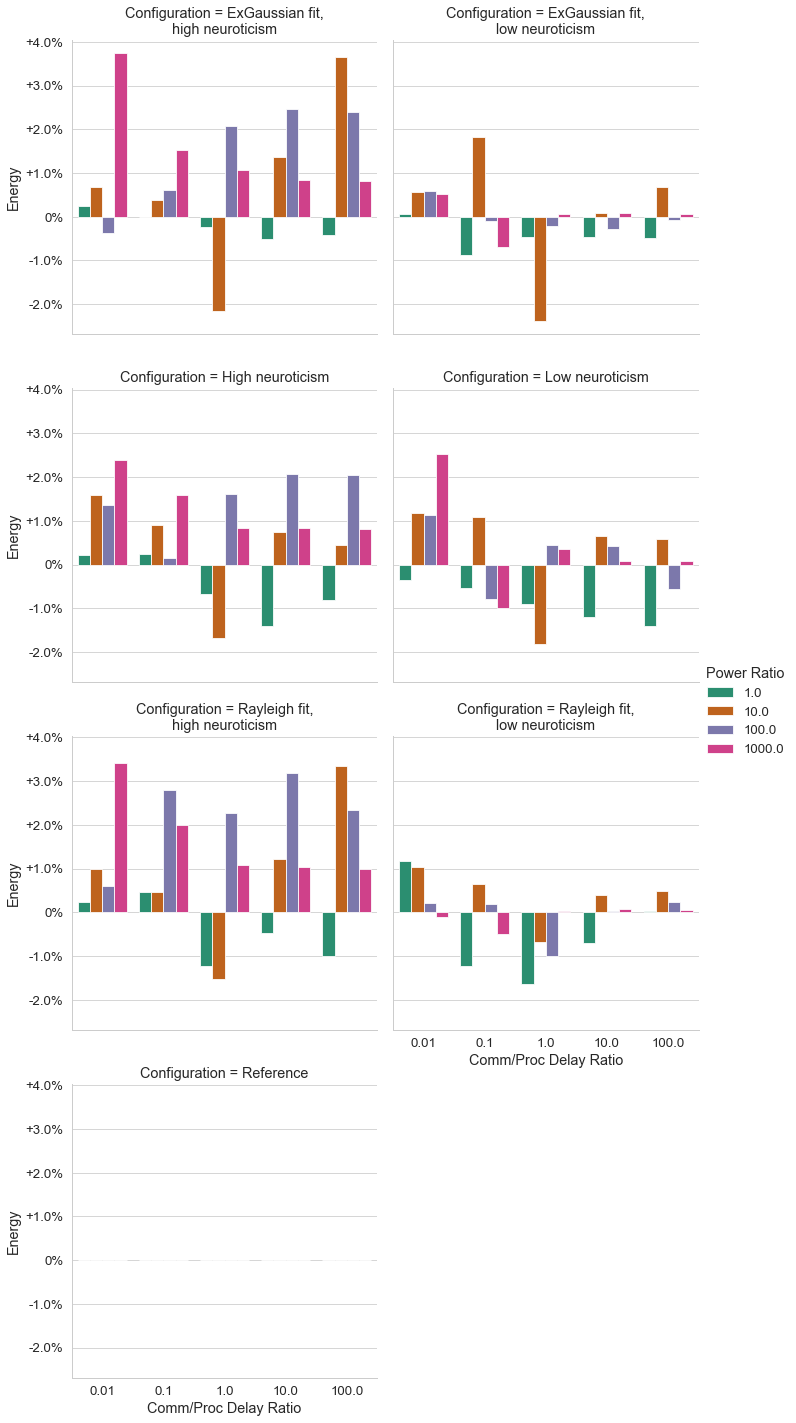

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import pandas as pd
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("Dark2")

fg = sns.catplot(
    kind="bar",
    data=mean_e_diff.reset_index(),
    hue="Power Ratio",
    x="Comm/Proc Delay Ratio",
    y="Energy",
    col="Configuration",
    col_wrap=2,
)
for ax in fg.axes.flat:
    # ax.yaxis.set_major_locator(tkr.MaxNLocator(integer=True))
    # ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f"{y:0.0f}s"))
    ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f"{y:+0.1%}" if y != 0.0 else "0%"))
    # ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=35, ha="right", rotation_mode="anchor")
plt.show()

In [9]:
results.to_csv("/tmp/sampling.csv")

In [7]:
# import pingouin as pg
#
#
#
# ref_energy = results.loc[results["Estimator"] == "Reference", "Mean energy"].to_numpy()
# ref_mean = ref_energy.mean()
#
# def diff_wrt_to_reference(energy: pd.Series) -> pd.Series:
#     energy = energy.to_numpy()
#     energy_mean = energy.mean()
#
#     ttest = pg.ttest(energy, ref_energy, alternative="two-sided")
#     diff_raw = energy_mean - ref_mean
#     diff = diff_raw / ref_mean
#     ci = ttest.at["T-test", "CI95%"]
#
#     pval = ttest.at["T-test", "p-val"]
#     sig_pval = pval < 0.05
#
#     return pd.Series({
#         "diff"     : diff,
#         "diff_raw" : diff_raw,
#         "p-val"    : pval,
#         "p < 0.05" : sig_pval,
#         "CI95_Low" : ci[0] / ref_mean,
#         "CI95_High": ci[1] / ref_mean}, name="Result")
#
#
# diff_result = (
#     results
#     .groupby("Estimator")
#     ["Mean energy"]
#     .apply(diff_wrt_to_reference)
#     .unstack(level=-1)
# )
# diff_result